In [4]:
import pandas as pd
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)

In [5]:
samples = pd.read_excel('../data/samples.xlsx', sheet_name=None)

colonnes_a_supprimer = [
    'datdelhis',
    'CODITDBDF_PRO',
    'CRTAD_IND_0062',
    'CRTAD_IND_0205',
    'CRTAR_IND_0036',
    'id_client',
    'CODTYPPRS',
    'CRTOD_CMT_PRO_IND_0209',
    'CRTOP_AG_IND_0038',
    'CRTOP_IND_0038',
    'CRTOU_CCT_PRO_IND_0209',
    'DATCREENT',
    'DATRLNORG',
    'RATIO1',
    'RATIO3',
    'TOP_PRO_ACTIF',
    'IND_ACTIF',
    'IND_PER_PM',
    'CODCMNIEE',
    'CODPAY_NAISSANCE',
    'CODPAY_NATIONALITE',
    'CODPAY_RESIDENCE',
    'CODSEXPRS',
    'secteur_activite',
    'secteur_activite_bis',
    'INDPARDCD'
]

samples = samples
train = samples[list(samples.keys())[0]]
train = train.drop(columns=colonnes_a_supprimer)
test = samples[list(samples.keys())[1]]
test = test.drop(columns=colonnes_a_supprimer)
oot = samples[list(samples.keys())[2]]
oot = oot.drop(columns=colonnes_a_supprimer)
sample = pd.concat([train, test, oot], ignore_index=True)

### Test de Kruskal-Wallis (quantitatives-qualitatives)


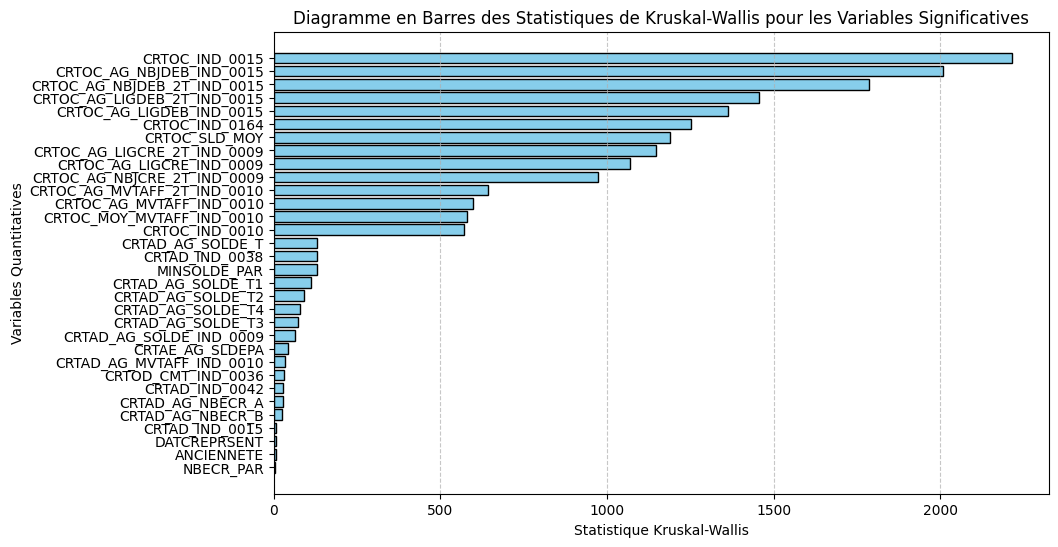

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import kruskal

df = train

# Séparer les groupes en fonction de la variable cible binaire
group_0 = df[df['DDefaut_NDB'] == 0]
group_1 = df[df['DDefaut_NDB'] == 1]

# Liste des colonnes qualitatives et quantitatives
qualitatives_cols = ['DDefaut_NDB','CODETAJUR','CODNAF2']
quantitative_cols = df.drop(columns=qualitatives_cols).columns

# Dictionnaire pour stocker les résultats
results = {}

# Appliquer le test de Kruskal-Wallis à chaque variable quantitative
for col in quantitative_cols:
    stat, p_value = kruskal(group_0[col], group_1[col])
    results[col] = {'Statistique': stat, 'p-value': p_value}

# Convertir le dictionnaire de résultats en DataFrame
results_df = pd.DataFrame(results).T

# Trier les résultats par la statistique du test (Statistique) de manière croissante
results_df_sorted = results_df.sort_values(by='Statistique', ascending=True)

# Filtrer les variables avec des p-value < 0.05 (significatives)
significant_results = results_df_sorted[results_df_sorted['p-value'] < 0.05]

# Créer un diagramme en barres des statistiques de Kruskal-Wallis pour les variables significatives
plt.figure(figsize=(10, 6))
plt.barh(significant_results.index, significant_results['Statistique'], color='skyblue', edgecolor='black')
plt.xlabel('Statistique Kruskal-Wallis')
plt.ylabel('Variables Quantitatives')
plt.title('Diagramme en Barres des Statistiques de Kruskal-Wallis pour les Variables Significatives')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()

### Test de Pearson (quantitatives-quantitatives)

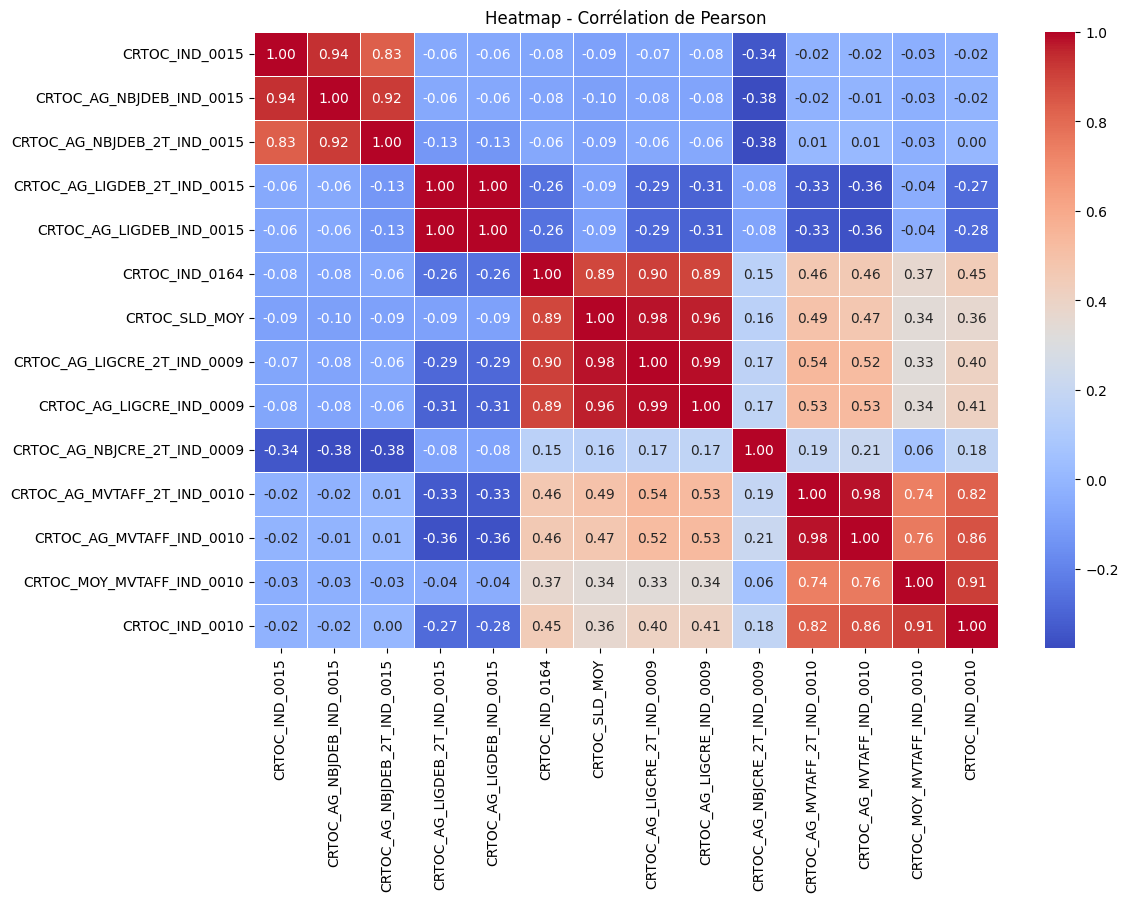

In [7]:
quantitative_cols_after_wallis = ['CRTOC_IND_0015',
                                  'CRTOC_AG_NBJDEB_IND_0015',
                                  'CRTOC_AG_NBJDEB_2T_IND_0015',
                                  'CRTOC_AG_LIGDEB_2T_IND_0015',
                                  'CRTOC_AG_LIGDEB_IND_0015',
                                  'CRTOC_IND_0164',
                                  'CRTOC_SLD_MOY',
                                  'CRTOC_AG_LIGCRE_2T_IND_0009',
                                  'CRTOC_AG_LIGCRE_IND_0009',
                                  'CRTOC_AG_NBJCRE_2T_IND_0009',
                                  'CRTOC_AG_MVTAFF_2T_IND_0010',
                                  'CRTOC_AG_MVTAFF_IND_0010',
                                  'CRTOC_MOY_MVTAFF_IND_0010',
                                  'CRTOC_IND_0010']

df = train[quantitative_cols_after_wallis]

# Calcul de la corrélation de Pearson
pearson_corr = df.corr(method='pearson')

# Plot de la heatmap pour la corrélation de Pearson
plt.figure(figsize=(12, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap - Corrélation de Pearson')
plt.show()

quantitative_cols_after_wallis_pearson = ['CRTOC_IND_0015', 'CRTOC_AG_LIGDEB_2T_IND_0015', 'CRTOC_IND_0164', 'CRTOC_AG_NBJCRE_2T_IND_0009', 'CRTOC_AG_MVTAFF_2T_IND_0010', 'CRTOC_MOY_MVTAFF_IND_0010']

### V de Cramer

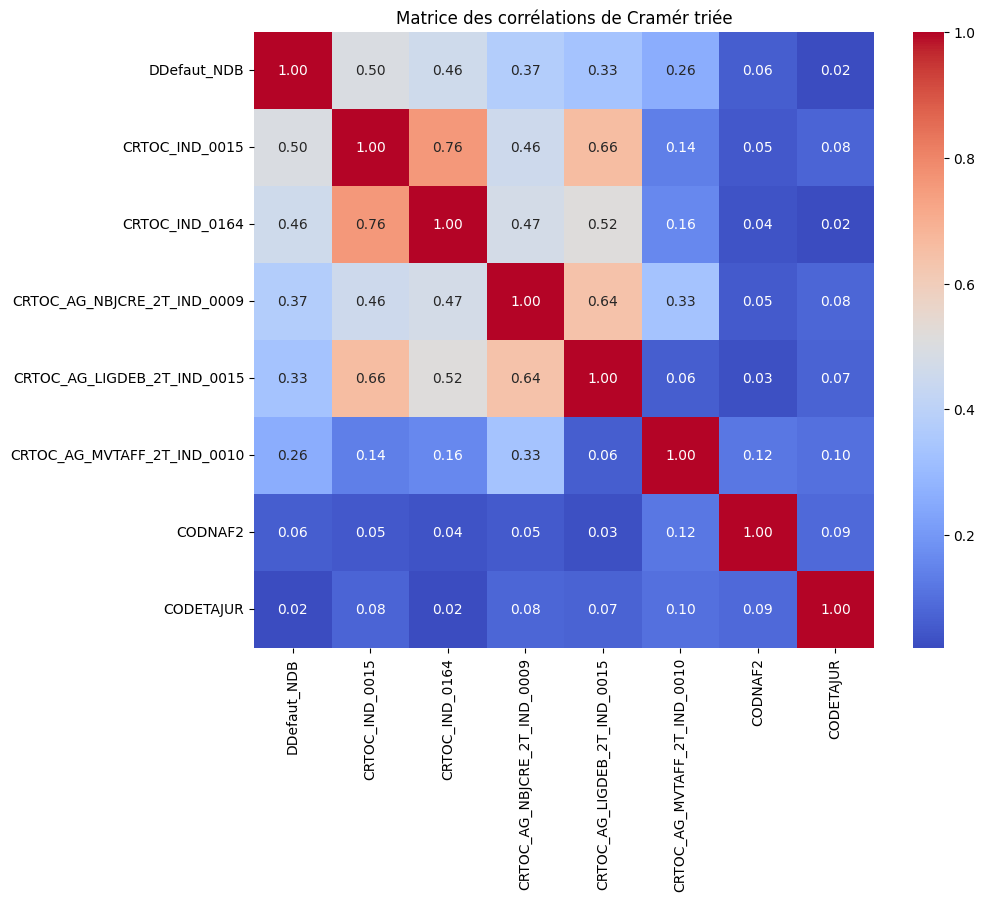

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_excel('../data/discretized_train.xlsx')

# Extraire les colonnes qualitatives
qualitatives_cols = df.columns

# Convertir toutes les colonnes en type string pour éviter les problèmes
df[qualitatives_cols] = df[qualitatives_cols].astype(str)

# Fonction pour calculer le V de Cramer
def cramers_v(confusion_matrix):
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    k = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * k)) if k > 0 else 0

# Calculer la matrice de corrélations de Cramér
def cramers_v_matrix(data, cols):
    n = len(cols)
    matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                matrix[i, j] = 1.0
            else:
                try:
                    confusion_matrix = pd.crosstab(data[cols[i]], data[cols[j]])
                    matrix[i, j] = cramers_v(confusion_matrix)
                except Exception as e:
                    print(f"Erreur avec les colonnes {cols[i]} et {cols[j]}: {e}")
                    matrix[i, j] = np.nan
    
    return pd.DataFrame(matrix, index=cols, columns=cols)

# Calculer la matrice des corrélations
cramer_matrix = cramers_v_matrix(df, qualitatives_cols)

# Trier les lignes et colonnes par corrélation avec DDefaut_NDB
if 'DDefaut_NDB' in cramer_matrix.columns:
    # Trier les colonnes par corrélation absolue avec DDefaut_NDB
    sorted_indices = cramer_matrix['DDefaut_NDB'].drop('DDefaut_NDB').sort_values(ascending=False).index
    # Placer DDefaut_NDB en première position
    sorted_indices = ['DDefaut_NDB'] + sorted_indices.tolist()
    # Réorganiser la matrice
    cramer_matrix = cramer_matrix.loc[sorted_indices, sorted_indices]

# Afficher la heatmap triée
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Matrice des corrélations de Cramér triée")
plt.show()


Nous prenons comme seuil 0.2 pour la corrélation avec la cible et 0.7 pour la multicolinéarité. Il reste donc: 
- CRTOC_IND_0015
- CRTOC_AG_NBJCRE_2T_IND_0009
- CRTOC_AG_LIGDEB_2T_IND_0015
- CRTOC_AG_MVTAFF_2T_IND_0010

In [9]:
train = pd.read_excel('../data/discretized_train.xlsx')
test = pd.read_excel('../data/discretized_test.xlsx')
oot = pd.read_excel('../data/discretized_oot.xlsx')
sample = pd.read_excel('../data/discretized_sample.xlsx')

# Liste des colonnes à conserver
columns_to_keep = ["DDefaut_NDB",
    "CRTOC_IND_0015",
    "CRTOC_AG_NBJCRE_2T_IND_0009",
    "CRTOC_AG_LIGDEB_2T_IND_0015",
    "CRTOC_AG_MVTAFF_2T_IND_0010"
]

# Sélectionner uniquement ces colonnes dans le DataFrame
train_filtered = train[columns_to_keep]
test_filtered = test[columns_to_keep]
oot_filtered = oot[columns_to_keep]
sample_filtered = sample[columns_to_keep]

In [10]:
train.to_excel('../data/final_train.xlsx', index=True)
test.to_excel('../data/final_test.xlsx', index=True)
oot.to_excel('../data/final_oot.xlsx', index=True)
sample.to_excel('../data/final_sample.xlsx', index=True)